In [ ]:
#!/usr/bin/env python
# coding: utf-8

import random
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy

class Model(torch.nn.Module):
    '''
    Input (y, A, H, P)
    y, observation vector
    P, Covariance

    x(t+1) = A x(t) + ξ(t)
    y(t) = H x(t) + ω(t)
    x ∈ R^n, state
    y ∈ R^m, observation
    {ξ}_t∈Z, uncorrelated zero-mean process
    {ω}_t∈Z, measurement noise vectors
    E[ξ(t)ξ(t)^T] = Q
    E[ω(t)ω(t)^T] = R
    Q & R, unknown
    P, error covariance matrix
    ̂x(0) = m_0, P(t_0) = P_0

    Prediction problem
    ̂y_P(T) = H ̂x_P(T)
    ̂x(t+1) = A ̂x(t) + L(t) ( y(t) - H x̂(t) )

    Kalman gain
    L(t) := A P(t) H^T ( H P(t) H^T + R )^(-1)
    P(t) = E[(x(t) - ̂x(t))(x(t) - ̂x(t))^T]
    P(t+1) = ( A - L(t) H ) P(t) A^T + Q
    P converges when (A,H) is observable and the (A, Q^(1/2)) is controllable
    L_∞ = A P_∞ H^T ( H P_∞ H^T + R )^(-1)
    '''
    def __init__(self, A, H, init, gpu=True):
        super().__init__()
        if gpu:
            if torch.cuda.is_available():
                gpu = 'cuda'
            elif torch.backends.mps.is_available():
                gpu = 'mps'
            else:
                gpu = 'cpu'
        else:
            gpu = 'cpu'
        self.device = torch.device(gpu)
        print('Using device:', self.device)
        self.n = A.shape[0]
        self.m = H.shape[0]
        #weights = torch.distributions.Uniform(0,0.5).sample((self.n,self.m))
        weights = torch.Tensor(init + np.random.rand()/10).to(self.device)
        self.A = torch.Tensor(A).to(self.device)
        self.H = torch.Tensor(H).to(self.device)
        self.weights = torch.nn.Parameter(weights)

    def forward(self, y, N):
        A = self.A
        H = self.H
        L = self.weights
        y = torch.Tensor(y).to(self.device)
        xhat = torch.zeros((self.n,N+1), device=self.device)
        yhat = torch.zeros((self.m,N), device=self.device)
        for k in range(N):
            if torch.isnan(xhat[:,k][0]):
                print(A @ xhat[:,k-2])
                print(L @ (y[:,k-2] - H @ xhat[:,k-2]))
                print(xhat[:,k-1])
                breakpoint()
            xhat[:,k+1] = A @ xhat[:,k] + L @ (y[:,k] - H @ xhat[:,k])
            yhat[:,k] = H @ xhat[:,k]
        return yhat

def sgd(model, y, N, steps=1000, lr=1e-3, opt_params='adam', gpu=True):
    '''
    y, observation vector
    N, time steps
    steps, optimising num of loops
    lr, learning rate
    '''
    losses = np.zeros(steps)
    gains = np.zeros((model.H.shape[1],model.H.shape[0],steps))

    if opt_params == 'adam':
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    elif opt_params == 'sgd':
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        assert True, "Not supported optimizer"

    if gpu:
        if torch.cuda.is_available():
            gpu = 'cuda'
        elif torch.backends.mps.is_available():
            gpu = 'mps'
        else:
            gpu = 'cpu'
    else:
        gpu = 'cpu'
    device = torch.device(gpu)
    y = torch.Tensor(y).to(device)
    model = model.to(device)

    pbar = tqdm(total=steps, unit='epochs')
    for i in range(steps):
        preds = model(y,N)
        loss = torch.functional.F.mse_loss(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        losses[i] = loss
        gains[:,:,i] = model.weights.cpu().detach()
        pbar.update(1)
    pbar.close()
    preds = model(y,N).cpu().detach().numpy()
    return losses, preds, gains

In [ ]:
def series_mass_spring_damp(T, q, r, P_0, Ts=0.1, n_series=1):
    '''
    m x''(t) + c x'(t) + k x(t) = 0
    mass (kg)
    cdamp, damping coefficient (N/m^2)
    kspring, spring constant (Ns/m)
    force (N)
    Ts, time step (s)
    N, simulation length (simulation time x time steps)

    E[ξ(t)ξ(t)^T] = Q
    E[ω(t)ω(t)^T] = R

    x(t+1) = A x(t) + ξ(t)
    y(t) = H x(t) + ω(t)
    {ξ}_t∈Z, uncorrelated zero-mean process
    {ω}_t∈Z, measurement noise vectors
    x(t) ∈ R^n, state of the system
    y(t) ∈ R^m
    '''
    cdamp = 4
    kspring = 2
    mass = 20
    force = 10
    N = int(T/Ts)
    M = np.eye(n_series) * mass
    K = np.zeros((n_series,n_series))
    C = np.zeros((n_series,n_series))
    K[0,0] = -kspring
    C[0,0] = -cdamp
    for idx in range(n_series-1):
        K[idx:idx+2,idx:idx+2] += np.array([[-kspring, kspring],
                                            [kspring,-kspring]])
        C[idx:idx+2,idx:idx+2] += np.array([[-cdamp, cdamp],
                                            [cdamp,-cdamp]])

    A = Ts * ( np.block([[np.zeros((n_series,n_series)), np.eye(n_series)],
                         [np.linalg.inv(M) @ K, np.linalg.inv(M) @ C]]) )
    A += np.eye(A.shape[0])

    n = A.shape[0]
    m = n
    H = np.eye(n)
    #m = 1
    #H = np.zeros((m,n))
    #H[0][-2] = 1 #choose output
    B = Ts * ( 1/mass * np.append(np.zeros(n-1), 1) )
    Q = np.eye(n) * q
    R = np.eye(m) * r
    u = force

    x = np.zeros((n,N+1))
    y = np.zeros((m,N))
    m_0 = np.random.normal(0, P_0, size=n)
    ξ = np.random.multivariate_normal(np.zeros(n), Q, N+1).T
    ω = np.random.multivariate_normal(np.zeros(m), R, N).T
    forcing = True
    c_forcing = False
    initial = False
    if initial:
        x[:,0] += m_0
    if forcing:
        x[:,0] += B * u
    for k in range(N):
        # x[:,k+1] = A @ x[:,k] + B * u + ξ[:,k]
        # y[:,k] = H @ x[:,k] + ω[:,k]
        x[:,k+1] = A @ x[:,k] + ξ[:,k]
        if c_forcing:
            x[:,k+1] += B * u
        y[:,k] = H @ x[:,k] + ω[:,k]
    return x[:,:-1], y, A, H, Q, R, K, C, B

In [ ]:
def main(n_series):
    Ts = 0.1
    P_0 = 0.05
    T = 100
    steps = 1000
    q = 0.1
    r = 0.1
    n, m = n_series**2, n_series**2

    N = int(T/Ts)

    x, y, A, H, Q, R, K, C, B = series_mass_spring_damp(T, q, r, P_0, n_series=n_series)

    #Q = np.eye(n) * 0.2
    #R = np.eye(m) * 0.2
    P = scipy.linalg.solve_discrete_are(A.T,H.T,Q,R)
    L = A @ P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

    model = Model(A, H, L, gpu=True)
    losses, preds, weights = sgd(model, y, N, steps, lr=8e-3, gpu=True)

    #Q = np.eye(n) * q
    #R = np.eye(m) * r
    #P = scipy.linalg.solve_discrete_are(A.T,H.T,Q,R)
    #L = A @ P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

    # APA^T - APH^T (HPH^T + R)^(-1) HPA^T + Q - P = 0
    t = np.arange(0, T, Ts)
    n, m = A.shape[0], H.shape[0]

    print('|====================================================================================================|')
    print('  Horizon:', T)
    print('  Time Steps:', Ts)
    print('  Mass-Spring-Damper num of series:', n_series)
    print('  n, m: ', n, m)
    print('  K:\n', K)
    print('  C:\n', C)
    print('  B:\n', B)
    print('  A: \n', A)
    print('  Q: \n', Q)
    print('  H: \n', H)
    print('  R: \n', R)
    print("  Optimal Kalman Gain L: \n", weights[:,:,-1])
    print("  dimensions:", weights.shape)
    print('|----------------------------------------------------------------------------------------------------|')
    print("  DARE Kalman Gain L")
    print("  L: \n", L)
    print("  P: \n", P)
    print('|====================================================================================================|')

    # Validation
    x, y, A, H, Q, R, K, C, B = series_mass_spring_damp(T, q, r, P_0, n_series=n_series)
    preds = model(y,N).cpu().detach().numpy()

    return weights, L, m, n, preds, losses, t, y

Using device: cuda


100%|██████████| 1000/1000 [10:56<00:00,  1.52epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 1
  n, m:  2 2
  K:
 [[-2.]]
  C:
 [[-4.]]
  B:
 [0.    0.005]
  A: 
 [[ 1.    0.1 ]
 [-0.01  0.98]]
  Q: 
 [[0.1 0. ]
 [0.  0.1]]
  H: 
 [[1. 0.]
 [0. 1.]]
  R: 
 [[0.1 0. ]
 [0.  0.1]]
  Optimal Kalman Gain L: 
 [[ 0.66348833  0.03602997]
 [-0.0049106   0.62615108]]
  dimensions: (2, 2, 1000)
|----------------------------------------------------------------------------------------------------|
  DARE Kalman Gain L
  L: 
 [[0.62005995 0.07062337]
 [0.00289226 0.60118042]]
  P: 
 [[0.16271223 0.00630103]
 [0.00630103 0.15891279]]
|====================================================================================================|
Using device: cuda


100%|██████████| 1000/1000 [10:40<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 2
  n, m:  4 4
  K:
 [[-4.  2.]
 [ 2. -2.]]
  C:
 [[-8.  4.]
 [ 4. -4.]]
  B:
 [0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.1   0.  ]
 [ 0.    1.    0.    0.1 ]
 [-0.02  0.01  0.96  0.02]
 [ 0.01 -0.01  0.02  0.98]]
  Q: 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]
  H: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
  R: 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]
  Optimal Kalman Gain L: 
 [[ 0.64188474  0.0227889   0.11203381  0.01396884]
 [-0.01389225  0.63752639  0.00538966  0.08848178]
 [-0.02467592  0.02610646  0.56943184  0.01971111]
 [-0.00504087 -0.00812646 -0.01536372  0.62496811]]
  dimensions: (4, 4, 1000)
|----------------------------------------------------------------------------------------------------|
  DARE Ka

100%|██████████| 1000/1000 [10:39<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 3
  n, m:  6 6
  K:
 [[-4.  2.  0.]
 [ 2. -4.  2.]
 [ 0.  2. -2.]]
  C:
 [[-8.  4.  0.]
 [ 4. -8.  4.]
 [ 0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.    0.1   0.    0.  ]
 [ 0.    1.    0.    0.    0.1   0.  ]
 [ 0.    0.    1.    0.    0.    0.1 ]
 [-0.02  0.01  0.    0.96  0.02  0.  ]
 [ 0.01 -0.02  0.01  0.02  0.96  0.02]
 [ 0.    0.01 -0.01  0.    0.02  0.98]]
  Q: 
 [[0.1 0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.1 0. ]
 [0.  0.  0.  0.  0.  0.1]]
  H: 
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
  R: 
 [[0.1 0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0. ]
 [0.

100%|██████████| 1000/1000 [10:41<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 4
  n, m:  8 8
  K:
 [[-4.  2.  0.  0.]
 [ 2. -4.  2.  0.]
 [ 0.  2. -4.  2.]
 [ 0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.]
 [ 4. -8.  4.  0.]
 [ 0.  4. -8.  4.]
 [ 0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.    0.    0.1   0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.1   0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.1   0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.1 ]
 [-0.02  0.01  0.    0.    0.96  0.02  0.    0.  ]
 [ 0.01 -0.02  0.01  0.    0.02  0.96  0.02  0.  ]
 [ 0.    0.01 -0.02  0.01  0.    0.02  0.96  0.02]
 [ 0.    0.    0.01 -0.01  0.    0.    0.02  0.98]]
  Q: 
 [[0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.1 0.  0.

100%|██████████| 1000/1000 [10:39<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 5
  n, m:  10 10
  K:
 [[-4.  2.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.]
 [ 0.  2. -4.  2.  0.]
 [ 0.  0.  2. -4.  2.]
 [ 0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.]
 [ 0.  4. -8.  4.  0.]
 [ 0.  0.  4. -8.  4.]
 [ 0.  0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.    0.    0.    0.1   0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.1   0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.1   0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.1   0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.1 ]
 [-0.02  0.01  0.    0.    0.    0.96  0.02  0.    0.    0.  ]
 [ 0.01 -0.02  0.01  0.    0.    0.02  0.96  0.02  0.    0.  ]
 [ 0.    0.01 -0.02  0.01  0.    0.    0.02  0.96  

100%|██████████| 1000/1000 [10:40<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 6
  n, m:  12 12
  K:
 [[-4.  2.  0.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.  0.]
 [ 0.  2. -4.  2.  0.  0.]
 [ 0.  0.  2. -4.  2.  0.]
 [ 0.  0.  0.  2. -4.  2.]
 [ 0.  0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.  0.]
 [ 0.  4. -8.  4.  0.  0.]
 [ 0.  0.  4. -8.  4.  0.]
 [ 0.  0.  0.  4. -8.  4.]
 [ 0.  0.  0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.1   0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.    0.1   0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.1   0.  ]
 [ 0.    0.

100%|██████████| 1000/1000 [10:45<00:00,  1.55epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 7
  n, m:  14 14
  K:
 [[-4.  2.  0.  0.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.  0.  0.]
 [ 0.  2. -4.  2.  0.  0.  0.]
 [ 0.  0.  2. -4.  2.  0.  0.]
 [ 0.  0.  0.  2. -4.  2.  0.]
 [ 0.  0.  0.  0.  2. -4.  2.]
 [ 0.  0.  0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.  0.  0.]
 [ 0.  4. -8.  4.  0.  0.  0.]
 [ 0.  0.  4. -8.  4.  0.  0.]
 [ 0.  0.  0.  4. -8.  4.  0.]
 [ 0.  0.  0.  0.  4. -8.  4.]
 [ 0.  0.  0.  0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.005]
  A: 
 [[ 1.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.    0.
   0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.
   0.    0.  ]
 [ 0.    0.    1.    0.    0.    0.    0.    0.    0.    0.1   0.    0.
   0.    0.  ]
 [ 0.

100%|██████████| 1000/1000 [10:42<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 8
  n, m:  16 16
  K:
 [[-4.  2.  0.  0.  0.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.  0.  0.  0.]
 [ 0.  2. -4.  2.  0.  0.  0.  0.]
 [ 0.  0.  2. -4.  2.  0.  0.  0.]
 [ 0.  0.  0.  2. -4.  2.  0.  0.]
 [ 0.  0.  0.  0.  2. -4.  2.  0.]
 [ 0.  0.  0.  0.  0.  2. -4.  2.]
 [ 0.  0.  0.  0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.  0.  0.  0.]
 [ 0.  4. -8.  4.  0.  0.  0.  0.]
 [ 0.  0.  4. -8.  4.  0.  0.  0.]
 [ 0.  0.  0.  4. -8.  4.  0.  0.]
 [ 0.  0.  0.  0.  4. -8.  4.  0.]
 [ 0.  0.  0.  0.  0.  4. -8.  4.]
 [ 0.  0.  0.  0.  0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.    0.    0.    0.    0.    0.    0.1   0.    0.    0.
   0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.

100%|██████████| 1000/1000 [10:43<00:00,  1.55epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 9
  n, m:  18 18
  K:
 [[-4.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  2. -4.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  2. -4.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  2. -4.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  2. -4.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  2. -4.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  2. -4.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.  0.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  4. -8.  4.  0.  0.  0.  0.  0.]
 [ 0.  0.  4. -8.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  4. -8.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  4. -8.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  4. -8.  4.  0.]
 [ 0.  0.  0.  0.  0.  0.  4. -8.  4.]
 [ 0.  0.  0.  0.  0.  0.  0.  4. -4.]]
  B:
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    

100%|██████████| 1000/1000 [10:39<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 10
  n, m:  20 20
  K:
 [[-4.  2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 2. -4.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2. -4.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2. -4.  2.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  2. -4.  2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2. -4.  2.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  2. -4.  2.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  2. -4.  2.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  2. -4.  2.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2. -2.]]
  C:
 [[-8.  4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 4. -8.  4.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4. -8.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  4. -8.  4.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4. -8.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4. -8.  4.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  4. -8.  4.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  4. -8.  4.  0.]
 [ 0.  0.  0.  0.  0.  

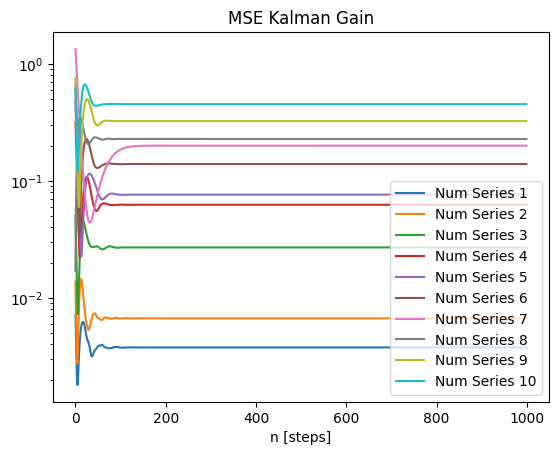

In [ ]:
n_series_range = 10
plt.figure()
for n_series in range(n_series_range):
  weights, L, m, n, preds, losses, t, y = main(n_series+1)
  mse = (np.expand_dims(L,axis=-1) - weights)**2
  plt.semilogy( np.sum(mse, axis=(0,1)), label='Num Series {}'.format(n_series+1) )
  plt.title('MSE Kalman Gain')
  plt.xlabel('n [steps]')
  plt.legend()
  plt.grid()
plt.show()

Using device: cuda


100%|██████████| 1000/1000 [10:39<00:00,  1.56epochs/s]


|====================================================================================================|
  Horizon: 100
  Time Steps: 0.1
  Mass-Spring-Damper num of series: 2
  n, m:  4 4
  K:
 [[-4.  2.]
 [ 2. -2.]]
  C:
 [[-8.  4.]
 [ 4. -4.]]
  B:
 [0.    0.    0.    0.005]
  A: 
 [[ 1.    0.    0.1   0.  ]
 [ 0.    1.    0.    0.1 ]
 [-0.02  0.01  0.96  0.02]
 [ 0.01 -0.01  0.02  0.98]]
  Q: 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]
  H: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
  R: 
 [[0.1 0.  0.  0. ]
 [0.  0.1 0.  0. ]
 [0.  0.  0.1 0. ]
 [0.  0.  0.  0.1]]
  Optimal Kalman Gain L: 
 [[ 0.62253433  0.01311228  0.07041898  0.06506425]
 [-0.01533705  0.65601766 -0.00849269  0.02919869]
 [-0.03890051 -0.0317018   0.6053021   0.0485879 ]
 [ 0.02147212 -0.02085966 -0.01511514  0.59495896]]
  dimensions: (4, 4, 1000)
|----------------------------------------------------------------------------------------------------|
  DARE Ka

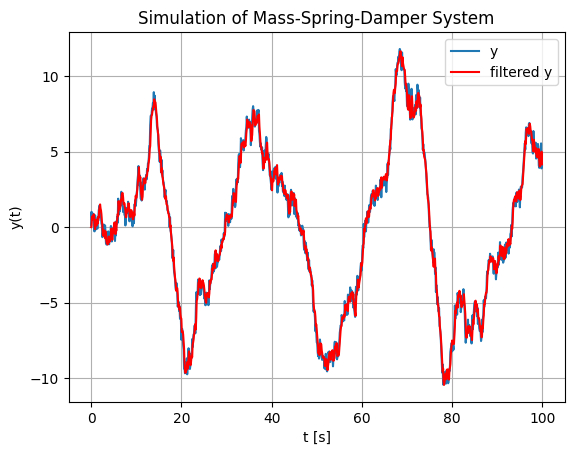

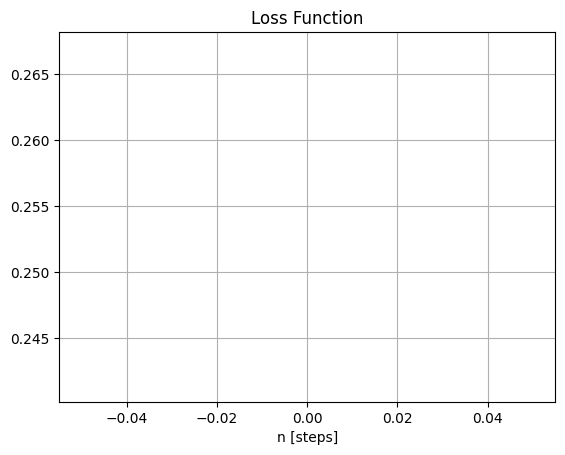

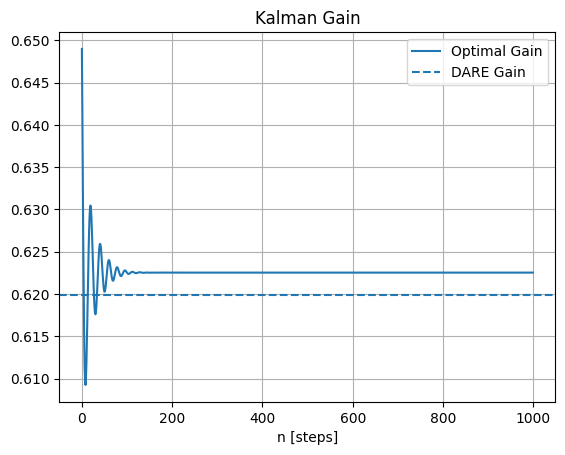

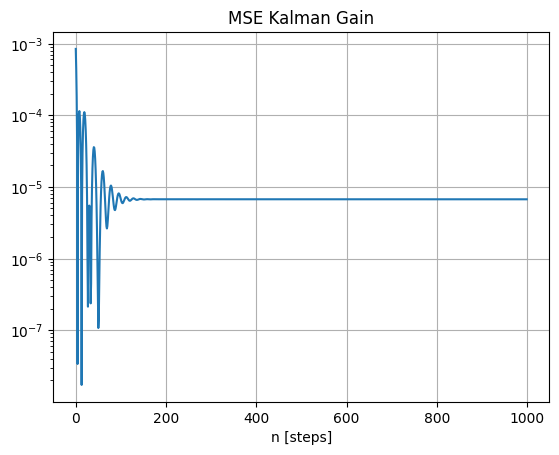

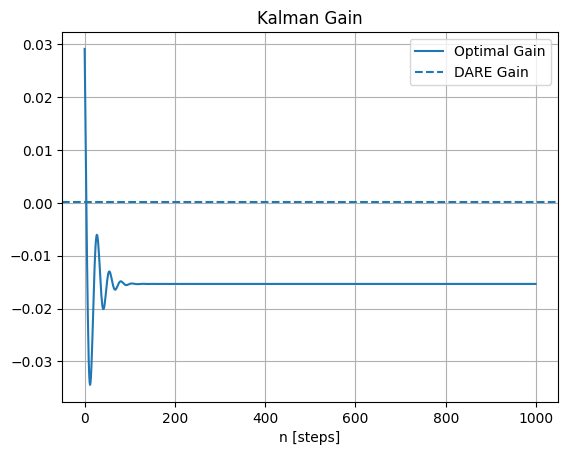

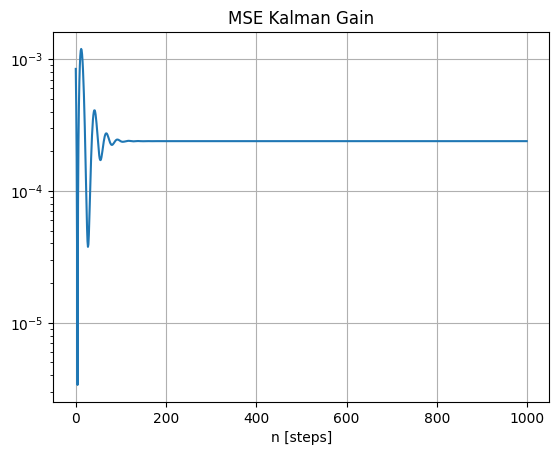

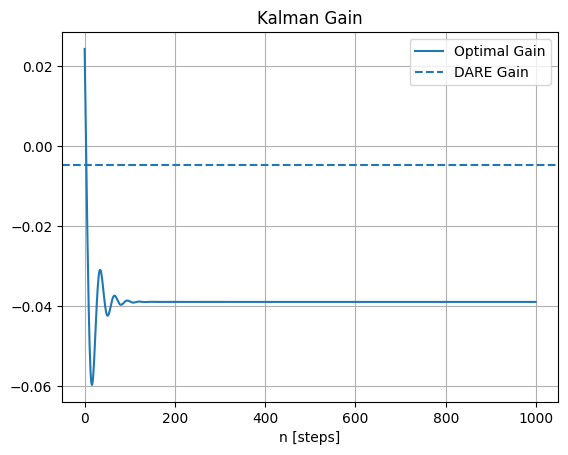

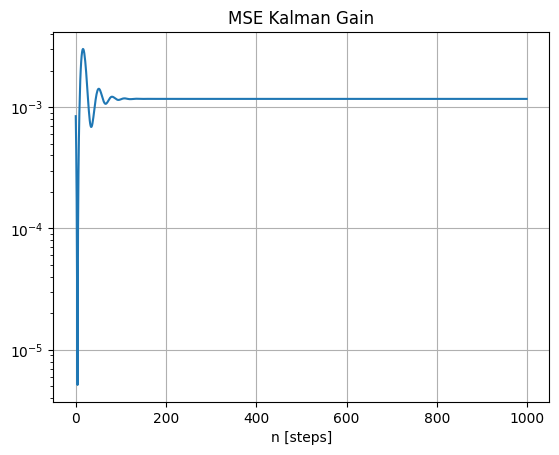

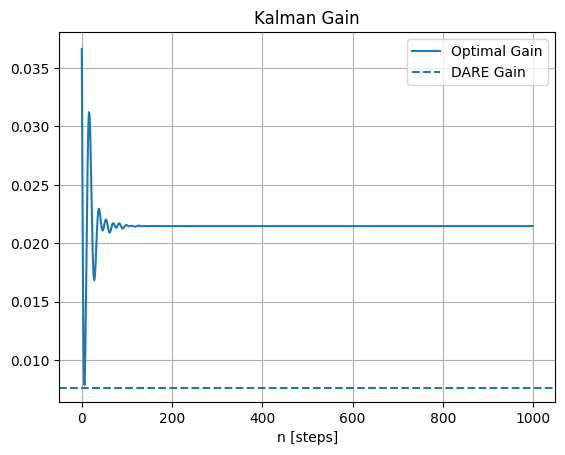

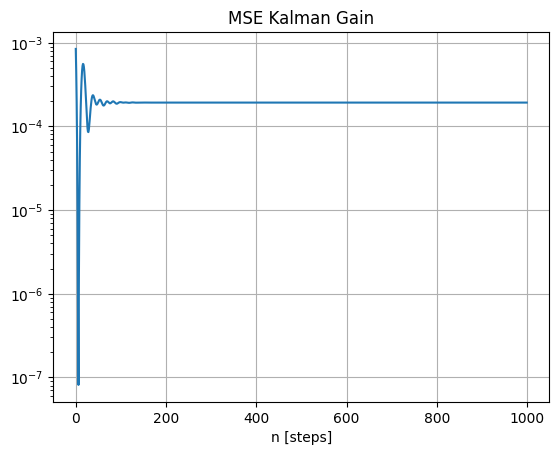

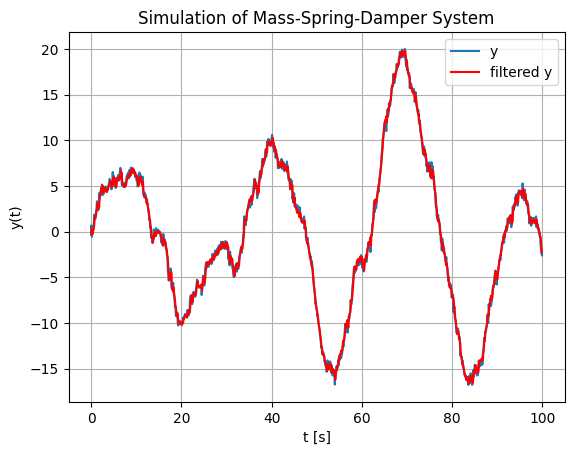

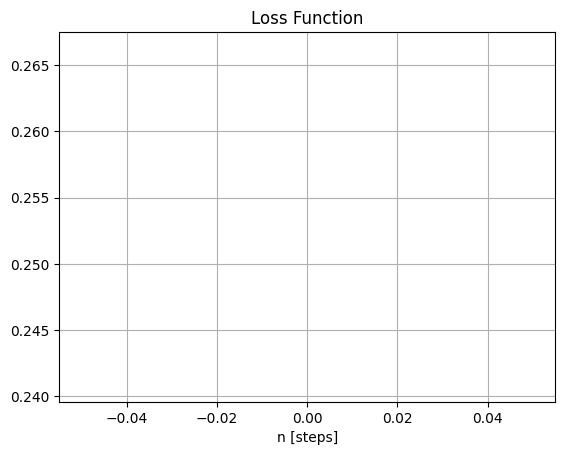

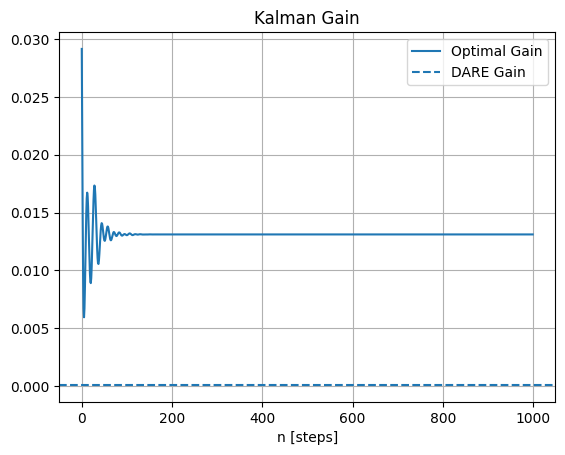

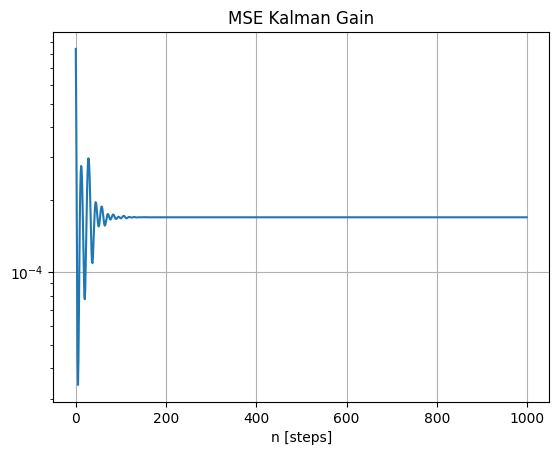

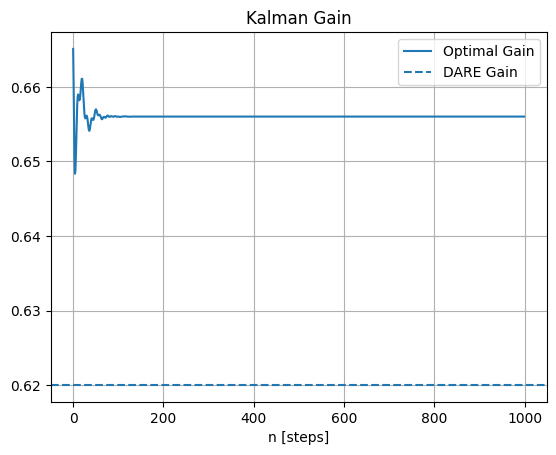

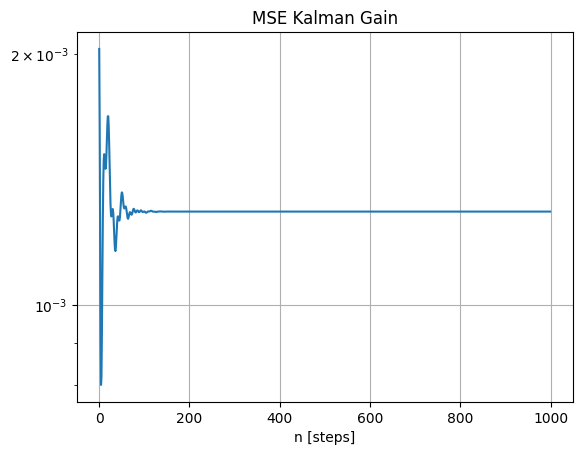

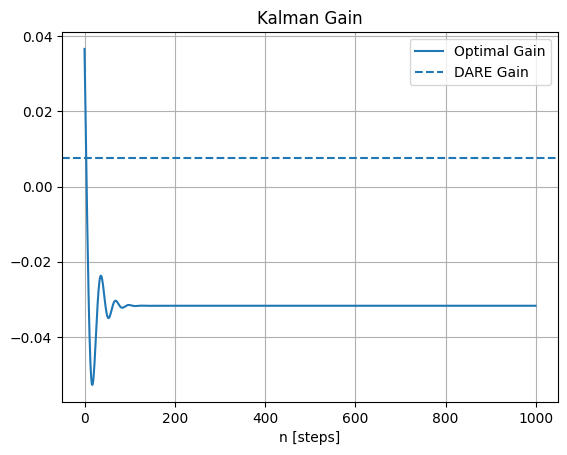

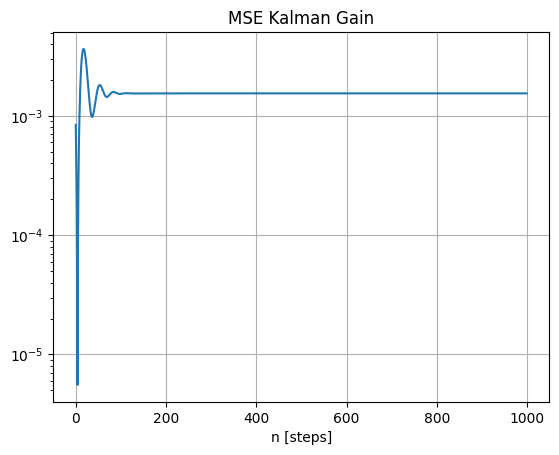

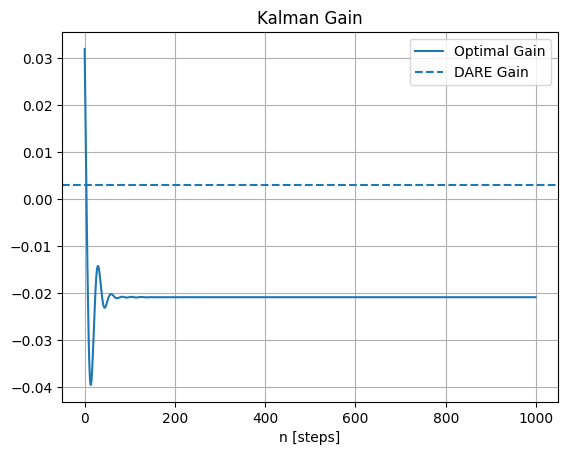

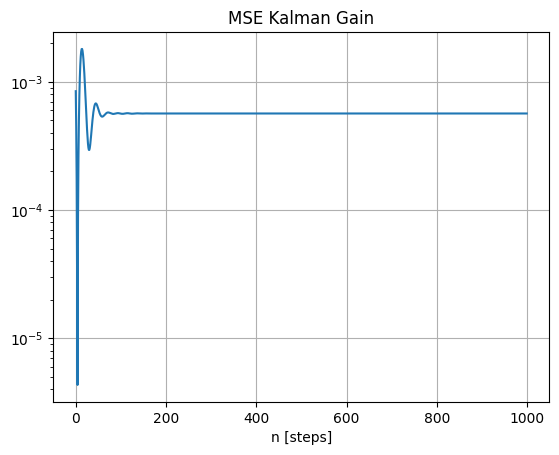

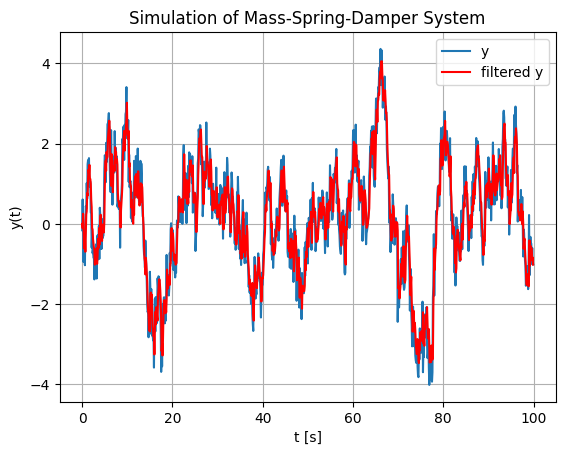

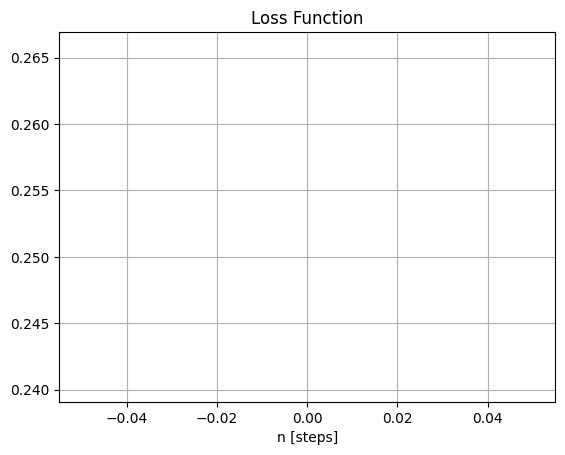

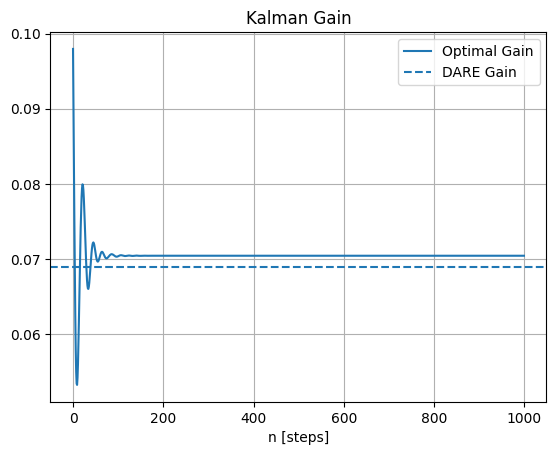

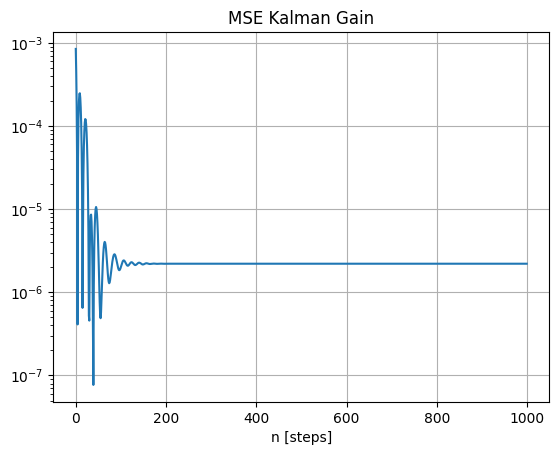

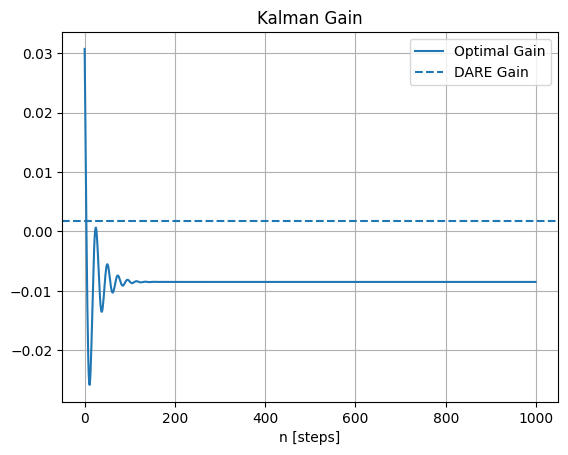

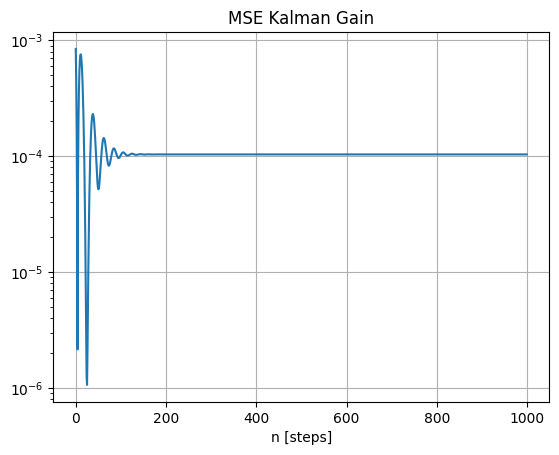

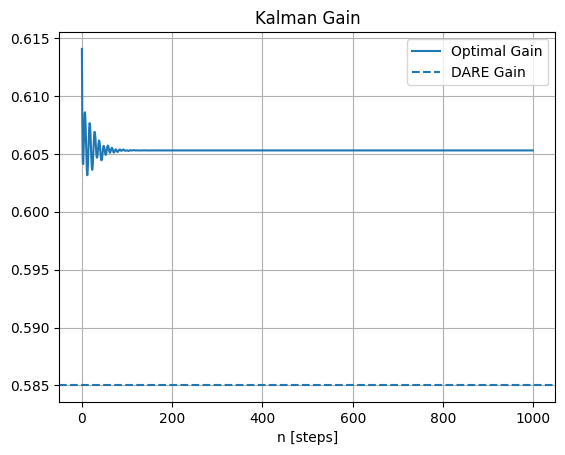

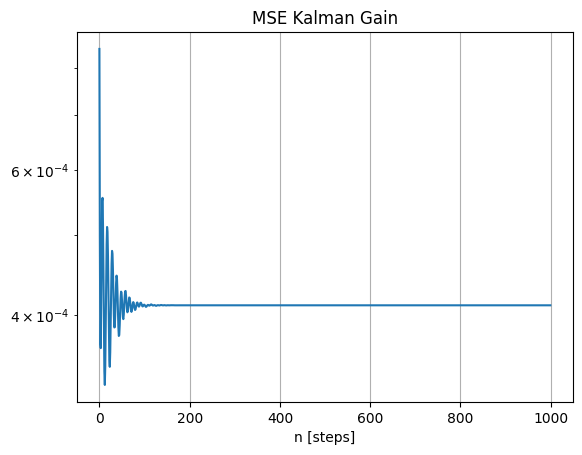

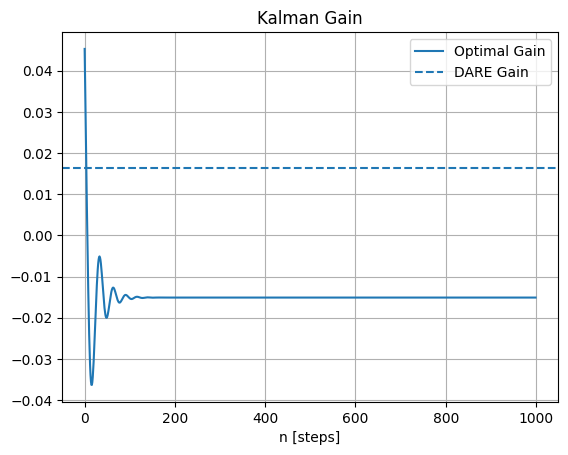

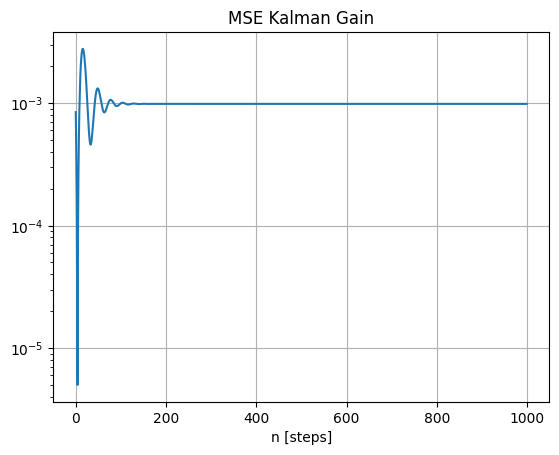

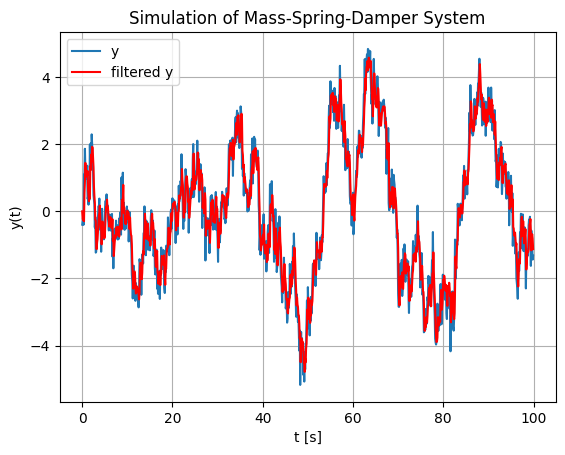

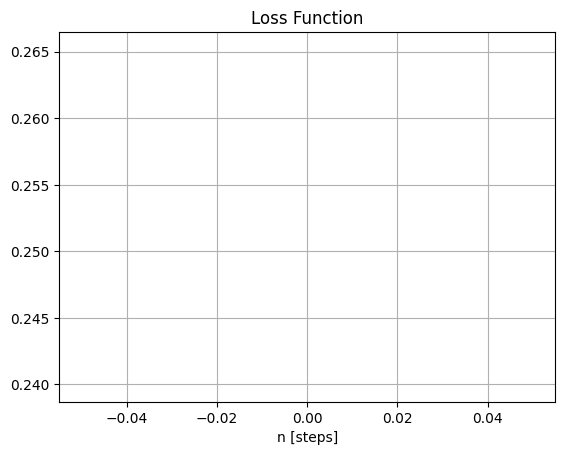

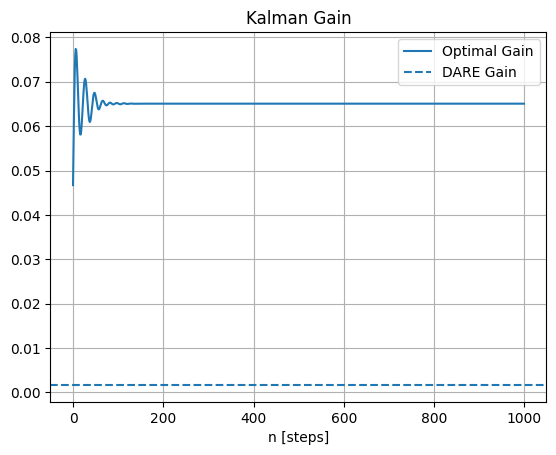

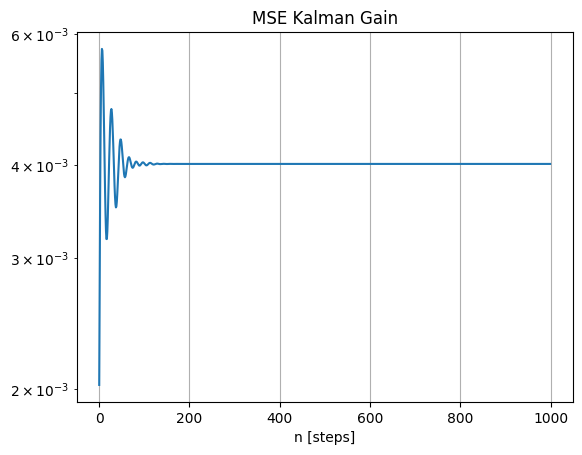

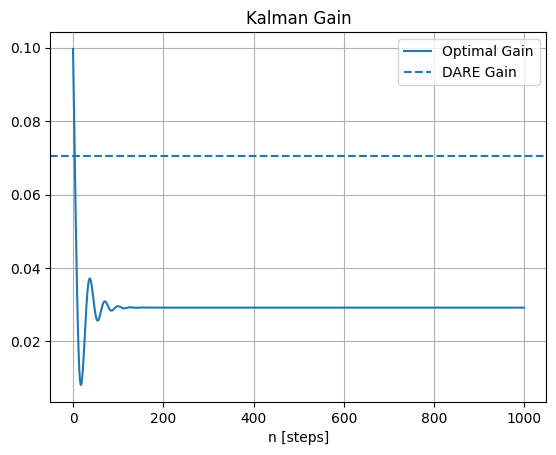

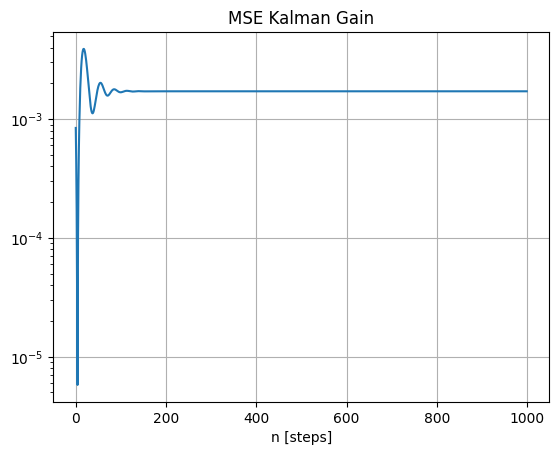

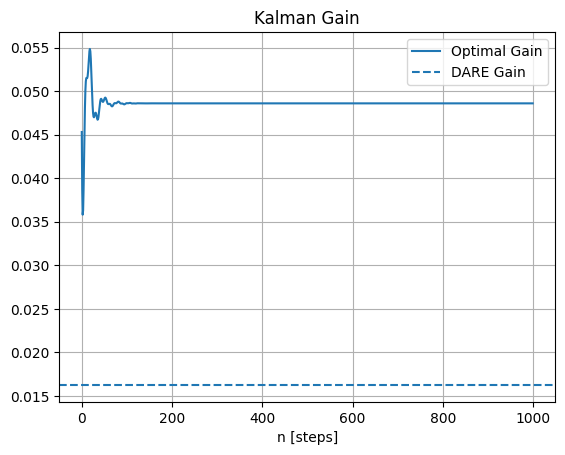

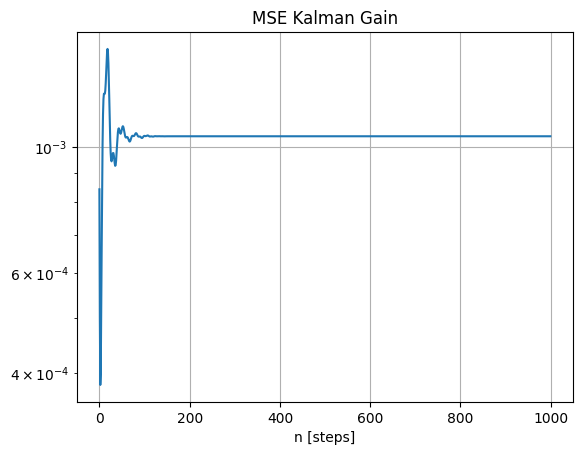

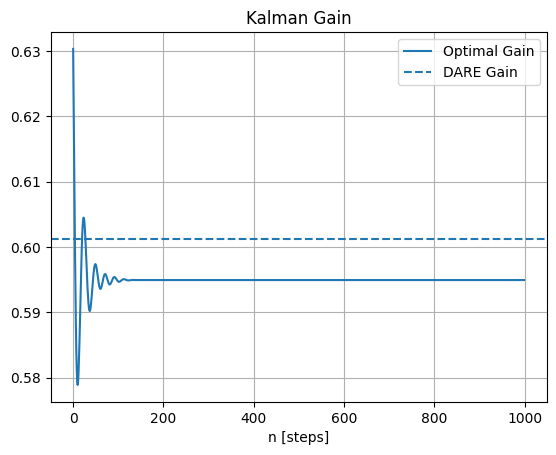

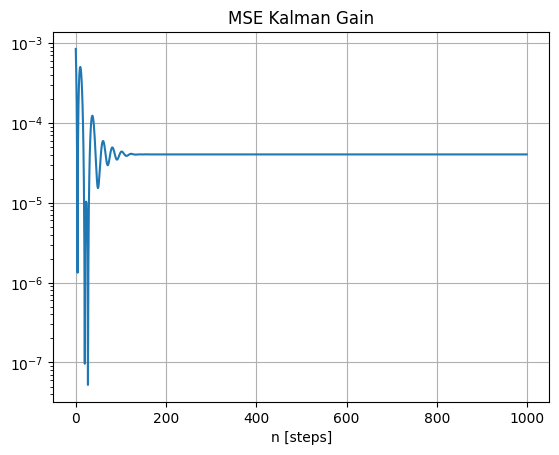

In [ ]:
weights, L, m, n, preds, losses, t, y = main(n_series=2)

for i in range(m):

    plt.figure()
    plt.plot(t, y[i])
    plt.plot(t, preds[i], color='r')
    plt.title('Simulation of Mass-Spring-Damper System')
    plt.xlabel('t [s]')
    plt.ylabel('y(t)')
    plt.grid()
    plt.legend(["y", "filtered y"])
    plt.show()

    plt.figure()
    plt.plot(losses[i])
    plt.title('Loss Function')
    plt.xlabel('n [steps]')
    plt.grid()
    plt.show()

    for j in range(n):
        plt.figure()
        plt.plot(weights[j][i])
        plt.axhline(L[j][i], linestyle='--')
        plt.title('Kalman Gain')
        plt.xlabel('n [steps]')
        plt.legend(["Optimal Gain", "DARE Gain"])
        plt.grid()
        plt.show()

        plt.figure()
        plt.semilogy((L[j][i] - weights[j][i])**2)
        plt.title('MSE Kalman Gain')
        plt.xlabel('n [steps]')
        plt.grid()
        plt.show()
